Этот код содержит реализацию VIT из этой [статьи](https://arxiv.org/abs/2010.11929).

## Setup

In [1]:
import torch
import torchvision
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt


import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm
import pickle
import torch.autograd as autograd
from  sklearn.model_selection import train_test_split
from sklearn.feature_extraction import image
from sklearn.utils import shuffle
import tensorflow as tf

from torch.utils.tensorboard import SummaryWriter
from typing import Tuple, List, Type, Dict, Any
from os.path import join, isfile, isdir

from queue import Empty, Queue
from threading import Thread
import threading
# augmentation library
from imgaug.augmentables import Keypoint, KeypointsOnImage
import imgaug.augmenters as iaa 

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


##Connect CUDA

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Проверим доступность GPU
torch.cuda.device_count()
if torch.cuda.is_available() :
  print(torch.cuda.get_device_properties(DEVICE))

_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [5]:
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

## Prepare the data ImageNet

Для обучения и теста будем использовать ImageNet. Большой набор весит около 166 Гб, поэтому используем mimi набор, его нужно положить на googledisk в папку и указать до неё путь.

https://www.kaggle.com/whitemoon/miniimagenet

https://data.deepai.org/miniimagenet.zip

Большой набор:

https://www.kaggle.com/c/imagenet-object-localization-challenge/data?select=imagenet_object_localization_patched2019.tar.gz

In [6]:
#разархивируйте миниархив в папку на привязанном гугл диске, и вставьте ссылка на неё сюда 
data_in = open("/content/drive/MyDrive/miniimagenet/mini-imagenet-cache-train.pkl", "rb")

data = pickle.load(data_in)

data_images = data['image_data']
data_size = data_images.shape[0]
data_labels_dict = data['class_dict']

num_classes = len(data_labels_dict)

In [7]:
print(f'data size {data_size}')

data size 38400


In [8]:
print(f'num classes {num_classes}')

num classes 64


In [9]:
labels_mapper = {}
for i,k in enumerate(data_labels_dict.keys()):
    labels_mapper[k] = i

In [10]:
#преобразование labels
def get_explicit_labels(labels_dict, data_size,labels_mapper, num_classes):
    labels = np.zeros((data_size,), dtype = int)
    prob_labels = np.zeros((data_size,num_classes))
    for i in range(data_size):
        
        for  k in labels_dict.keys():
          if(i in labels_dict[k]):
              labels[i] = int(labels_mapper[k])
              prob_labels[i][int(labels_mapper[k])] = 1.
              break
    return labels, prob_labels  


In [11]:
data_labels , data_prob_labels = get_explicit_labels(data_labels_dict, data_size,labels_mapper, num_classes)

In [12]:
train_images, test_images, train_labels, test_labels, train_prob_labels, test_prob_labels = train_test_split(data_images, data_labels, data_prob_labels , test_size = 0.2, stratify= data_labels)

In [13]:
print('test labels distribution')
print(pd.DataFrame(test_labels)[0].value_counts())

test labels distribution
63    120
59    120
53    120
49    120
45    120
     ... 
22    120
18    120
14    120
10    120
0     120
Name: 0, Length: 64, dtype: int64


In [14]:
print('train labels distribution')
print(pd.DataFrame(train_labels)[0].value_counts())

train labels distribution
63    480
47    480
23    480
7     480
54    480
     ... 
25    480
9     480
56    480
40    480
0     480
Name: 0, Length: 64, dtype: int64


КОд ниже содержит только техническую реализацию нейронной сети, для подбора оптимальных параметров и обучения трогать его не нужно.

Реализация параллельных алгоритмов

In [15]:
class thread_killer(object):    
    """Boolean object for signaling a worker thread to terminate
    Once a thread is launched, it should be terminated at some moment.
    In case the function of this thread is an infinite loop, one needs a mutex
    for signaling a worker thread to break the loop.
    The fuction will return, and the thread will be terminated.
    """
    
    def __init__(self):
        self.to_kill = False

    def __call__(self):
        return self.to_kill

    def set_tokill(self, tokill):
        self.to_kill = tokill

In [16]:
def threaded_batches_feeder(tokill, batches_queue, dataset_generator):
    """
    Threaded worker for pre-processing input data.
    tokill (thread_killer): an object that indicates whether a thread should be terminated
    dataset_generator (Dataset): training/validation data generator
    batches_queue (Queue): a limited size thread-safe Queue instance for train/validation data batches
    """
    while tokill() == False:
        for sample_batch in dataset_generator:
            
            batches_queue.put(sample_batch, block=True)
            
            if tokill() == True:
                return

In [17]:
def threaded_cuda_batches(tokill, cuda_batches_queue, batches_queue):
    """
    Thread worker for transferring pytorch tensors into GPU. 
    batches_queue (Queue): the queue that fetches numpy cpu tensors.
    cuda_batches_queue (Queue): the queue receiving numpy cpu tensors and transfering them to GPU memory.
    """
    while tokill() == False:
        sample_batch,labels = batches_queue.get(block=True)
        sample_batch = Variable(sample_batch).to(DEVICE)
        labels = labels.to(DEVICE)
      
        
        cuda_batches_queue.put((sample_batch,labels), block=True)
        if tokill() == True:
            return

In [18]:
class Threadsafe_iter:
    """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return next(self.it)

def get_objects_id(objects_count):
    """Cyclic generator of paths indices"""
    current_objects_id = 0
    while True:
        yield current_objects_id
        current_objects_id  = (current_objects_id + 1) % objects_count

## Implement multilayer perceptron (MLP) and additional Conv 

In [19]:
def init_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [20]:
class  MLP(nn.Module):
  def __init__( self, layers_dims, dropout_rate = 0.1):
    super(MLP, self).__init__()
    self.layers_dims = layers_dims
    self.dropout_rate = dropout_rate
    self.layers = []
    for in_features, out_features in self.layers_dims:
        self.layers.append(
            nn.Sequential(nn.Linear(in_features, out_features).to(DEVICE),
                          nn.ReLU(),
                          nn.Dropout(self.dropout_rate))
            )
  def forward(self, x):
    for layer in self.layers:
        x =layer(x)
        
       
    return x


## Implement patch creation as a layer

In [21]:
class Patches(nn.Module):
    def __init__(self, patch_size, num_channels = 3):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_channels = num_channels

    def __call__(self, images):
        #Самая удобная реализация патчинга картинок есть на tensorflow
        images = tf.convert_to_tensor(images.detach().cpu().numpy().transpose(0,2,3,1))
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        patches = tf.reshape(patches, [batch_size,  patches.shape[1]* patches.shape[2], self.patch_size, self.patch_size,self.num_channels])
        return torch.Tensor(patches.numpy()).to(DEVICE)

    def forward(self, images):
        return __call__(images)

Display example image and its patching

([], <a list of 0 Text major ticklabel objects>)

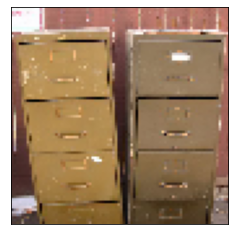

In [22]:
plt.imshow(train_images[0].astype(int))
plt.xticks([])
plt.yticks([])

Patching picture into 14 x 14 parts


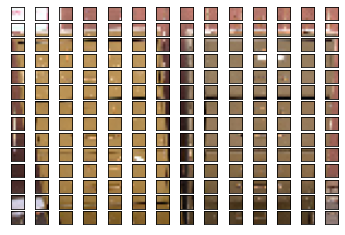

In [23]:
pic = train_images[:1]
PIL_pic = torch.zeros(1,3,84,84).to(DEVICE)
PIL_pic[0] = torchvision.transforms.Compose([
                                                      torchvision.transforms.ToPILImage(), 
                                                     torchvision.transforms.ToTensor()
                                                    ]) (pic[0])
p = Patches(patch_size = 6)
patches = p(PIL_pic)
patch = patches[0]
patch_row = int(np.sqrt(patch.shape[0]))
print(f'Patching picture into {patch_row } x {patch_row } parts')
for i in range(patch_row ):
    for j in range(patch_row ):

        plt.subplot( patch_row ,patch_row ,i*patch_row  + j + 1)
        plt.imshow(patch[i*patch_row  + j].cpu().numpy())
        plt.xticks([])
        plt.yticks([])

In [24]:
shuffle(pd.DataFrame(list(range(train_images.shape[0]))))
      

,0
1583,1583
6387,6387
9387,9387
12443,12443
23504,23504
...,...
11343,11343
6851,6851
27817,27817
24120,24120


In [25]:
class ImgDataset(Dataset):    
    def __init__(self, 
                 np_data, 
                 np_labels,
                 transform=None, 
                 batch_size = 8, 
                 augment = True,
                 seq = iaa.Sequential([iaa.GaussianBlur(sigma=(0, 5))],random_order=True), 
                 train = True):
        self.is_train = train
        self.np_data = np_data
        self.np_labels = np_labels

        self.id_df = pd.DataFrame(list(range(np_data.shape[0])))
      
        self.transform = transform
        
        self.batch_size = batch_size
        
        self.objects_id_generator = Threadsafe_iter(get_objects_id(self.id_df.shape[0]))
        
        self.lock = threading.Lock()
        self.yield_lock = threading.Lock()
        self.init_count = 0
        self.augment = augment
        self.cache = {}
        
        if self.augment:
            # instantiate augmentations
            self.seq = seq
        
    def __len__(self):                        
        return self.id_df.shape[0]
    

    def shuffle(self):
        self.id_df = shuffle(self.id_df).reset_index(drop=True)
    
    def __iter__(self):
        while True:
            with self.lock:
                if (self.init_count == 0):
                    if self.is_train:
                        self.shuffle()
                    self.imgs = []
                    self.labels = []
                
                    self.init_count = 1
            
            
            for obj_id in self.objects_id_generator:
                            
                label = self.np_labels[obj_id]      
                img = self.np_data[obj_id]
                img = torchvision.transforms.Compose([
                                                      torchvision.transforms.ToPILImage(), 
                                                     torchvision.transforms.ToTensor()
                                                    ])(img)
                if self.transform:
                    img = self.transform(img)
                img= img.numpy()
                                                 
                if self.augment:
                    img = self.seq(images = img)
                                                
                    # Concurrent access by multiple threads to the lists below
                with self.yield_lock:
                    if (len(self.imgs)) < self.batch_size:
                        self.imgs.append(img)
                        
                        self.labels.append(label)
                        
                    if (obj_id + 1 == len(self)):
                        yield (torch.Tensor(np.array(self.imgs)),(torch.Tensor(np.array(self.labels))))
                        self.imgs = []
                        self.labels = []
                        
                        break    
                    if len(self.imgs) % self.batch_size == 0:
                        
                        yield (torch.Tensor(np.array(self.imgs)),(torch.Tensor(np.array(self.labels))))
                        self.imgs = []
                        self.labels = []         
            # At the end of an epoch we re-init data-structures
            with self.lock:
                if self.is_train:
                    self.id_df = shuffle(self.id_df)
                self.init_count = 0

## Implement the patch encoding layer

Проецирует линейно на скрытое измерение и добавляет Positional Embedding

In [26]:

class PatchEncoder(nn.Module):
    def __init__(self, num_patches,patch_size, projection_dim,num_channels = 3, dropout = 0.1):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = nn.Linear(num_channels*patch_size**2, projection_dim)
        self.pos_embedding = nn.Embedding( num_patches, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([projection_dim])).to(DEVICE)
        self.num_channels = num_channels
    def forward(self, patch):
       
        unpack_shape = patch.shape
        patch = torch.flatten(patch, start_dim = 2)
        patch = torch.flatten(patch, end_dim = 1)
        patch = self.projection(patch)
        patch = nn.Unflatten(0, unpack_shape[:2])(patch)
        
        pos = torch.arange(0, self.num_patches).unsqueeze(0).repeat(patch.shape[0], 1).to(DEVICE)
        
        patch = self.dropout(patch/self.scale  + self.pos_embedding(pos))
        
        return patch


## ViT model

Трасформерные блоки используют Multiheadattention, как механизм запоминания картинок по патчам. 



In [27]:
class Transformer_Encoder_Layer(nn.Module):
    def __init__(self, num_heads, hid_dim,mlp_layers_dims, dropout = 0.1):
        super(Transformer_Encoder_Layer, self).__init__()
        self.num_heads = num_heads
        self.hid_dim = hid_dim
        
        self.norm_before_multihead = nn.LayerNorm(hid_dim)
        self.multihead = nn.MultiheadAttention(hid_dim, num_heads, dropout =dropout)
        self.norm_after_multihead = nn.LayerNorm(hid_dim)
        self.mlp = MLP(mlp_layers_dims).to(DEVICE)
        self.mlp.apply(init_weights)

    # Create multiple layers of the Transformer block.
    def forward(self, x):
        # Layer normalization 1.
        _x = x.clone()
        x = self.norm_before_multihead(x)
        # Create a multi-head attention layer.
        attention_output,_ = self.multihead(x,x,x)
        # Skip connection 1.
        x = _x + attention_output
        # Layer normalization 2.
        _x = x.clone()
        x = self.norm_after_multihead(x)
        # MLP.
        x = self.mlp.forward(x)
        # Skip connection 2.
        x  =_x + x
        return x


In [28]:
class VIT(nn.Module):
    def __init__(self, patch_size,num_patches,projection_dim,transformer_layers_config,mlp_head_layers_dim , num_channels = 3, start_head = False):
        super(VIT, self).__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.patch_size = patch_size
        self.num_channels = num_channels
        #дополнительная начальная CNN
        self.start_head = start_head
        if(self.start_head == True):
            
            self.start_CNN =  CNN().to(DEVICE)
        self.patches = Patches(patch_size, num_channels = num_channels)
        self.patch_encoding = PatchEncoder(num_patches, patch_size,projection_dim, num_channels = num_channels)
        self.transformer_layers = []
        for num_heads, config in transformer_layers_config:
            self.transformer_layers.append (Transformer_Encoder_Layer(num_heads, projection_dim,config ).to(DEVICE))
        self.final_representation= nn.Sequential(
            nn.LayerNorm( transformer_layers_config[-1][1][-1][1]),
            nn.Flatten(start_dim=1),
            nn.Dropout(0.5)
        )
        self.MLP_head = MLP(mlp_head_layers_dim ).to(DEVICE)
        self.MLP_head.apply(init_weights)

    def forward(self,x):
      if(self.start_head == True):
        x = self.start_CNN(x)

      x = self.patches(x)
      x = self.patch_encoding(x)
      for layer in self.transformer_layers:
            x = layer(x)
      x = self.final_representation(x)
      x = self.MLP_head(x)
      #log soft max устойчивей чем простой
      output = x
      return output


## Compile, train, and evaluate the mode

In [29]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       STEPS_PER_EPOCH,
                       train_cuda_batches_queue,
                       data_len):
    model.train()
    loss_sum = 0
    accuracy = 0

    for image_batch in tqdm(range(STEPS_PER_EPOCH), total=STEPS_PER_EPOCH):
      
        x,y = train_cuda_batches_queue.get(block = True)
        
        model.zero_grad()
        hyp = model(x)
       
      
        loss = loss_function(hyp, y)
        loss.backward()
        loss_sum += loss
        
        optimizer.step()
        
        optimizer.step()
        y_pred = hyp.argmax(dim = 1, keepdim = True).to(DEVICE)
        y_hat = y.argmax(dim = 1, keepdim = True).to(DEVICE)
        accuracy += y_pred.eq(y_hat.view_as(y_pred)).sum().item()

    
    accuracy_avr = 100 * accuracy / float(data_len)
    
    return {'loss' : loss_sum.item()/float(data_len), 'accuracy' : accuracy_avr}
    
    

In [30]:
@torch.no_grad()
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module,                          
                          STEPS_PER_EPOCH,
                          test_cuda_batches_queue,
                          data_len):
    model.eval()
    loss_sum = 0
    accuracy = 0
    
    for image_batch in range(STEPS_PER_EPOCH):
        
        x,y = test_cuda_batches_queue.get(block = True)

        hyp = model(x)
        loss = loss_function(hyp, y)
        loss_sum += loss

        y_pred = hyp.argmax(dim = 1, keepdim = True).to(DEVICE)
        y_hat = y.argmax(dim = 1, keepdim = True).to(DEVICE)
        accuracy += y_pred.eq(y_hat.view_as(y_pred)).sum().item()

    loss_avr = loss_sum / float(data_len)
    accuracy_avr = 100 * accuracy / float(data_len)
    
    return {'loss' : loss_avr.item(), 'accuracy' : accuracy_avr}

In [31]:
def ploting_curves(loss, best_epoch):
    """
    Plot loss evolution on training and validation sets
    """
    # Plot learning loss curve
    plt.plot(loss['train'], label = 'Training set')
    plt.plot(loss['valid'], label = 'Val set')
    plt.axvline(best_epoch, color = 'r', ls = '--', label = 'Best model')
    plt.title('Loss evolution')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [43]:
def train_model(model: torch.nn.Module, 
                train_data,
                
                train_prob_labels,
                test_data,
                
                test_prob_labels,
                augmentation,
                transformation,

                save_link,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim.AdamW,
                optimizer_params: Dict = { 'betas':  (0.9, 0.999), 'eps' :1e-9 , 'weight_decay' : 1e-4  },
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 16,
                max_epochs = 1000,
                early_stopping_patience = 20):
    # set to training mode
 
    ImgData_train = ImgDataset(np_data = train_data, np_labels = train_prob_labels, batch_size= batch_size, augment = False)
    ImgData_test = ImgDataset(np_data = test_data,  np_labels = test_prob_labels ,batch_size= batch_size, augment= False, train = False)
    
    STEPS_PER_EPOCH_TRAIN = math.ceil(len(ImgData_train)/ float(batch_size)) 
    STEPS_PER_EPOCH_TEST = math.ceil(len(ImgData_test)/ float(batch_size)) 

    #Настроики на трайн
    train_batches_queue_length = min(STEPS_PER_EPOCH_TRAIN, 4)    
    train_batches_queue = Queue(maxsize=train_batches_queue_length)
    train_cuda_batches_queue = Queue(maxsize=4)
    train_thread_killer = thread_killer()
    train_thread_killer.set_tokill(False)
    train_preprocess_workers = 24

    for _ in range(train_preprocess_workers):
        thr = Thread(target=threaded_batches_feeder, args=(train_thread_killer, train_batches_queue, ImgData_train))
        thr.start()

    train_cuda_transfers_thread_killer = thread_killer()
    train_cuda_transfers_thread_killer.set_tokill(False)
    train_cudathread = Thread(target=threaded_cuda_batches, args=(train_cuda_transfers_thread_killer, train_cuda_batches_queue, train_batches_queue))
    train_cudathread.start()

    #Настроики на тест  
    test_batches_queue_length = min(STEPS_PER_EPOCH_TEST, 4)    
    test_batches_queue = Queue(maxsize=test_batches_queue_length)
    test_cuda_batches_queue = Queue(maxsize=4)
    test_thread_killer = thread_killer()
    test_thread_killer.set_tokill(False)
    test_preprocess_workers = 24

    for _ in range(test_preprocess_workers):
        thr = Thread(target=threaded_batches_feeder, args=(test_thread_killer, test_batches_queue, ImgData_test))
        thr.start()

    test_cuda_transfers_thread_killer = thread_killer()
    test_cuda_transfers_thread_killer.set_tokill(False)
    test_cudathread = Thread(target=threaded_cuda_batches, args=(test_cuda_transfers_thread_killer, test_cuda_batches_queue, test_batches_queue))
    test_cudathread.start()
    # Everything is ready for the training
  
    model.to(DEVICE)
    optimizer = optimizer_class(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    best_val_loss = None
    best_epoch = None
    loss_list = {'train': list(), 'valid': list()}
    

    for epoch in range(max_epochs):
        
        print(f'Epoch {epoch}')
    
        train_loss =  train_single_epoch(model, optimizer, loss_function,STEPS_PER_EPOCH_TRAIN, train_cuda_batches_queue, len(ImgData_train))
        print(f'Train metrics: \n{train_loss}')
        print('Validating epoch\n')

        val_metrics = validate_single_epoch(model, loss_function, STEPS_PER_EPOCH_TEST, test_cuda_batches_queue, len(ImgData_test))
        loss_list['valid'].append(val_metrics['loss'])
        loss_list['train'].append(train_loss['loss'])
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
         
           
            torch.save(model,save_link)
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            ploting_curves(loss_list,best_epoch)
            break

    train_thread_killer.set_tokill(True)
    train_cuda_transfers_thread_killer.set_tokill(True)
    for _ in range(train_preprocess_workers):
        try:
            # Enforcing thread shutdown
            train_batches_queue.get(block=True, timeout=1)
            train_cuda_batches_queue.get(block=True, timeout=1)
        except Empty:
            pass

    test_thread_killer.set_tokill(True)
    test_cuda_transfers_thread_killer.set_tokill(True)
    for _ in range(test_preprocess_workers):
        try:
            # Enforcing thread shutdown
            test_batches_queue.get(block=True, timeout=1)
            test_cuda_batches_queue.get(block=True, timeout=1)
        except Empty:
            pass  
    return model, loss_list 


##Model config

Здесь происходит обуение и настройка параметров, можете экспериментировать и пробовать разные штуки на дефолтной модели нейронки, крайне советую почитать статью и посмотреть на их параметры для обучения.

Можно менять такие вещи как: оптимизатор, расписание и значение learning rate, финальную MLP голову модели и количество голов в трансформере, размерность скрытого измерения. Так же можно изначально поставить CNN сеть и из её выходов делать патчи.

In [33]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
num_channels = 3
image_size = 84  
patch_size = 6  
num_patches = (image_size // patch_size) ** 2
projection_dim = 64


Настройка стартовой головы

In [34]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.layer = nn.Sequential(nn.Conv2d(3, 4, 2), 
                                    nn.ReLU(),
                                    nn.Conv2d(4,8, 2,1),

                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=1)) 
        self.layer.apply(init_weights)
    def forward(self, x):
            return self.layer(x)

In [35]:
# проверить размерности выходного изображения
c =CNN()
new_patch_size = 3
# new_patch_size должен делиться на new_shape[2,3]
new_shape = c.forward(torch.Tensor(train_images[:3].transpose(0,3,1,2))).shape
print(new_shape)
new_num_patches = int(new_shape[2]/new_patch_size * new_shape[3]/new_patch_size)
new_num_channels = new_shape[1]
print(f'new num patches: {new_num_patches}' )

torch.Size([3, 8, 81, 81])
new num patches: 729


In [44]:
#здесь задаётся MLP в кадом слое трансформера
#один слой задётся tuple (кол-во голов в multiheadattention(должно быть делителем projection_dim) , list из слоёв в mlp первый и последний должны быть размерности projection_dim)
transformer_layers_config = [
                             (2,  [(projection_dim, 64), (64 ,128 ),(128 ,1024 ), (1024 ,2048 ), (2048, projection_dim)])
                             

                         ]
#тут задаётся только главная голова MLP
#Если сиспользуйте стартовую голову CNN не забудье поменять num_patches на new_num_patches
mlp_head_layers_dim = [(projection_dim*num_patches,256), (256,512) , (512,1024),(1024, 2048), ( 2048, num_classes)]


In [45]:
#если используйте стартовую CNN голову не забудьте поменять: patch_size , num_patches, num_channels на new_...
model = VIT(patch_size = patch_size, 
            num_patches = num_patches,
            projection_dim = projection_dim,
            transformer_layers_config = transformer_layers_config,
            mlp_head_layers_dim = mlp_head_layers_dim,
            num_channels=num_channels,
            start_head= False)
model.to(DEVICE)

VIT(
  (patches): Patches()
  (patch_encoding): PatchEncoder(
    (projection): Linear(in_features=108, out_features=64, bias=True)
    (pos_embedding): Embedding(196, 64)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (final_representation): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Dropout(p=0.5, inplace=False)
  )
  (MLP_head): MLP()
)

In [46]:
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters 19648


In [47]:
model.apply(init_weights)

VIT(
  (patches): Patches()
  (patch_encoding): PatchEncoder(
    (projection): Linear(in_features=108, out_features=64, bias=True)
    (pos_embedding): Embedding(196, 64)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (final_representation): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Dropout(p=0.5, inplace=False)
  )
  (MLP_head): MLP()
)

##Configure hyperparametrs

[Трансформации](https://pytorch.org/vision/stable/transforms.html)

In [40]:
#можете вертеть, отзеркаливать, вырезать части и блюрить картинки. Следите за тем, чтобы ответ при этом не менялся (например отзеркалить цифру 2 нельзя, это уже будет 5)
transformation  = torchvision.transforms.Compose([
                                      
])
#тоже самое, но это рфботает нестабильно, не используйте                                                ])
augmentation  =  iaa.Sequential([
                                  iaa.Fliplr(0.5), # horizontally flip 50% of the images
                                   iaa.GaussianBlur(sigma=(0, 3.0)),
                                   iaa.Flipud(0.5),
                                   iaa.Affine(rotate = (-30,30),scale=(0.5, 1.5))                                                    
                                  ])


[learning rate](https://)

In [48]:
#Это расписание learning rate с постепенным линейным нагревом, а потом убываением. Говорят, без него трансформер просто не обучить, так что обучайте на этом
initial_lr  = 0.8
warmup_epoch = 100
def lambda_lr (epoch):
    if(epoch <= warmup_epoch): 
        return initial_lr*(epoch+1) 
    else: 
        return   initial_lr/np.sqrt(epoch+1)

In [52]:
best_model,loss_list = train_model(model, #cама модель 
                train_images,
              
                train_prob_labels,
                test_images,
             
                test_prob_labels,
                #Сюда забейте ссылку куда кидать модели, обязательно их сохраняйте!!!!

                save_link =  '/content/drive/MyDrive/VIT_models/best_VIT_model_1.pth',
                #преобразование данных
                augmentation = None,
                transformation = transformation,
                #оптимизатор
                optimizer_class = torch.optim.AdamW,
                optimizer_params =  { 'betas':  (0.9, 0.999), 'eps' :1e-9 , 'weight_decay' : 1e-4  },
                #расписание learning rate
                lr_scheduler_class = torch.optim.lr_scheduler.MultiplicativeLR,
                lr_scheduler_params  = {'lr_lambda' : lambda_lr},
                
                batch_size = 256,
                initial_lr = initial_lr )

Epoch 0


 12%|█▏        | 14/120 [00:10<01:22,  1.29it/s]


KeyboardInterrupt: ignored

##RESNET

Здесь я дропнул код модели Resnet типа CNN, которые очень хорошо зарекомендовали себя  в классификации изображений. Попробуйте по аналогии с кодом выше обучить как pretrained, так и с 0 эти модели и посмотрите, какая точность достигается за 200 эпох

In [ ]:
class Pe_resnet512(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (84, 84),
                 input_channels: int = 3, 
                 hidden_layer_features: List[int] = [256, 256, 256],
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 64):
        
        super().__init__()

        self.input_resolution = input_resolution
        self.input_channels = input_channels
        self.hidden_layer_features = hidden_layer_features
        self.activation = activation
        self.num_classes = num_classes
        #pretrained будет перенасить уже хорошо обученные параметры в модель
        resnet152 = torchvision.models.resnet152(pretrained=True, progress=False)
        #тру - параметры модели будут обучаться, false -останутся как было
        for param in resnet152.parameters():
            param.requires_grad = False

        resnet152.fc = torch.nn.Sequential(torch.nn.Linear(2048, 128))

        self.layer = torch.nn.Sequential(resnet152,
                                         torch.nn.BatchNorm1d(128),
                                         torch.nn.ReLU(),
                                torch.nn.Linear(128,256),
                                torch.nn.BatchNorm1d(256),
                                torch.nn.ReLU(),
                                torch.nn.Linear(256,512),
                                torch.nn.BatchNorm1d(512),
                                torch.nn.ReLU(),
                                torch.nn.Linear(512,num_classes))
    
        
    def forward(self, x):
        
        x = self.layer(x)
        
        output = F.log_softmax(x, dim = 1)
        
        return output

In [ ]:
pe_resnet = Pe_resnet512(num_classes= num_classes)

In [ ]:
print('Total number of trainable parameters', 
      sum(p.numel() for p in pe_resnet.parameters() if p.requires_grad))

Total number of trainable parameters 461504


In [ ]:
best_model_resnet, loss_log_resnet = train_model(pe_resnet, #cама модель 
                train_images,
                train_labels,
                train_prob_labels,
                test_images,
                test_labels,
                test_prob_labels,
                save_link =  '/content/drive/MyDrive/VIT_models/best_resnet_model.pth',
                  #преобразование данных
                augmentation = None,
                transformation = transformation,
                #оптимизатор
                optimizer_class = torch.optim.AdamW,
                optimizer_params =  { 'betas':  (0.9, 0.999), 'eps' :1e-9 , 'weight_decay' : 1e-4  },
                #расписание learning rate
                lr_scheduler_class = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params  = {'patience' : 10, 'threshold': 1e-4},
                
                batch_size = 64,
                initial_lr = initial_lr )